## 1. Import Libraries

In [18]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
import textstat
from ftfy import fix_text
from num2words import num2words

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

!python -m spacy download en_core_web_md
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     --------------------------------------- 42.8/42.8 MB 28.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')



[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# load provided job postings
dataset_path = "../Raw Data Files/fake_job_postings.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [20]:
# load generated and scraped job postings
df_fraud_generated = pd.read_csv('../Scraping/Fake Data/cf_fakejobs.csv')
df_nofraud_scraped = pd.read_csv('../Scraping/CareersFuture/cleaned_data_nonfraud.csv')

df_fraud_generated['fraudulent'] = 1
df_nofraud_scraped['fraudulent'] = 0

dataset_cf = pd.concat([df_fraud_generated, df_nofraud_scraped], ignore_index=True)

dataset_cf.head()

,job_post_id,title,address,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,min_experience,company,industry,salary_type,fraudulent
0,MCF-2023-03021,Senior Project Manager,"50 Raffles Place, #15-01, Singapore Land Tower...",Project Management,12000-15000,Global Solutions Ltd. is a leading project man...,As a Senior Project Manager at Global Solution...,10+ years of project management experience,Competitive salary and bonus,0,0,1,Full-time,Mid-Level,8,Global Solutions Ltd.,Project Management,Monthly,1
1,MCF-2023-03022,Legal Counsel,"6 Battery Road, #20-01, Singapore 049909",Legal,15000-18000,LegalEase Partners is a reputable law firm pro...,LegalEase Partners is looking for a Legal Coun...,Law degree and bar admission,Healthcare and dental coverage,0,1,1,Full-time,Director,4,LegalEase Partners,Legal Services,Monthly,1
2,MCF-2023-03023,Data Analyst (Contract),"3 Church Street, Samsung Hub, Singapore 049483",Data Analysis,6000-8000,TechData Analytics is a data-driven company se...,Join TechData Analytics as a Data Analyst (Con...,Experience in data analysis preferred,Contract-based role,0,1,1,Contract,Senior Level,5,TechData Analytics,Data Analytics,Monthly,1
3,MCF-2023-03024,Marketing Director,"1 Raffles Quay, North Tower, Singapore 048583",Marketing,18000-22000,MaxiMedia Group is a marketing agency speciali...,MaxiMedia Group is in search of a Marketing Di...,10+ years of marketing experience,Performance-based bonuses,0,0,0,Full-time,Senior Level,2,MaxiMedia Group,Marketing,Monthly,1
4,MCF-2023-03025,UX/UI Designer,"9 Temasek Boulevard, #04-02, Suntec Tower Two,...",Design,8000-10000,DesignMasters Co. is a design studio dedicated...,DesignMasters Co. is hiring a UX/UI Designer t...,Strong portfolio of design work,Flexible work hours,0,0,1,Full-time,Senior Level,0,DesignMasters Co.,Design,Monthly,1


In [21]:
# clean generated and scraped job postings
dataset_cf['location'] = np.where(dataset_cf['address'].notna(), 'SG', '')
dataset_cf.rename(columns={'requirement': 'requirements', 'job_post_id': 'job_id'}, inplace=True)
del dataset_cf['address'], dataset_cf['company'], dataset_cf['industry'], dataset_cf['salary_type'], dataset_cf['min_experience']
dataset_cf.head()


,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,fraudulent,location
0,MCF-2023-03021,Senior Project Manager,Project Management,12000-15000,Global Solutions Ltd. is a leading project man...,As a Senior Project Manager at Global Solution...,10+ years of project management experience,Competitive salary and bonus,0,0,1,Full-time,Mid-Level,1,SG
1,MCF-2023-03022,Legal Counsel,Legal,15000-18000,LegalEase Partners is a reputable law firm pro...,LegalEase Partners is looking for a Legal Coun...,Law degree and bar admission,Healthcare and dental coverage,0,1,1,Full-time,Director,1,SG
2,MCF-2023-03023,Data Analyst (Contract),Data Analysis,6000-8000,TechData Analytics is a data-driven company se...,Join TechData Analytics as a Data Analyst (Con...,Experience in data analysis preferred,Contract-based role,0,1,1,Contract,Senior Level,1,SG
3,MCF-2023-03024,Marketing Director,Marketing,18000-22000,MaxiMedia Group is a marketing agency speciali...,MaxiMedia Group is in search of a Marketing Di...,10+ years of marketing experience,Performance-based bonuses,0,0,0,Full-time,Senior Level,1,SG
4,MCF-2023-03025,UX/UI Designer,Design,8000-10000,DesignMasters Co. is a design studio dedicated...,DesignMasters Co. is hiring a UX/UI Designer t...,Strong portfolio of design work,Flexible work hours,0,0,1,Full-time,Senior Level,1,SG


In [22]:
# combine all job postings
dataset = pd.concat([dataset, dataset_cf], ignore_index=True)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 2. Basic Understanding of the Data

In [23]:
print(dataset.shape)
dataset.info()

(25996, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25996 entries, 0 to 25995
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               25996 non-null  object
 1   title                25996 non-null  object
 2   location             25650 non-null  object
 3   department           14449 non-null  object
 4   salary_range         10979 non-null  object
 5   company_profile      22688 non-null  object
 6   description          25742 non-null  object
 7   requirements         17066 non-null  object
 8   benefits             11359 non-null  object
 9   telecommuting        25996 non-null  int64 
 10  has_company_logo     25996 non-null  int64 
 11  has_questions        25996 non-null  int64 
 12  employment_type      22525 non-null  object
 13  required_experience  18912 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [24]:
dataset.duplicated().sum()

0

In [25]:
dataset.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15017
company_profile         3308
description              254
requirements            8930
benefits               14637
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7084
required_education     16221
industry               13019
function               14571
fraudulent                 0
dtype: int64

<AxesSubplot:>

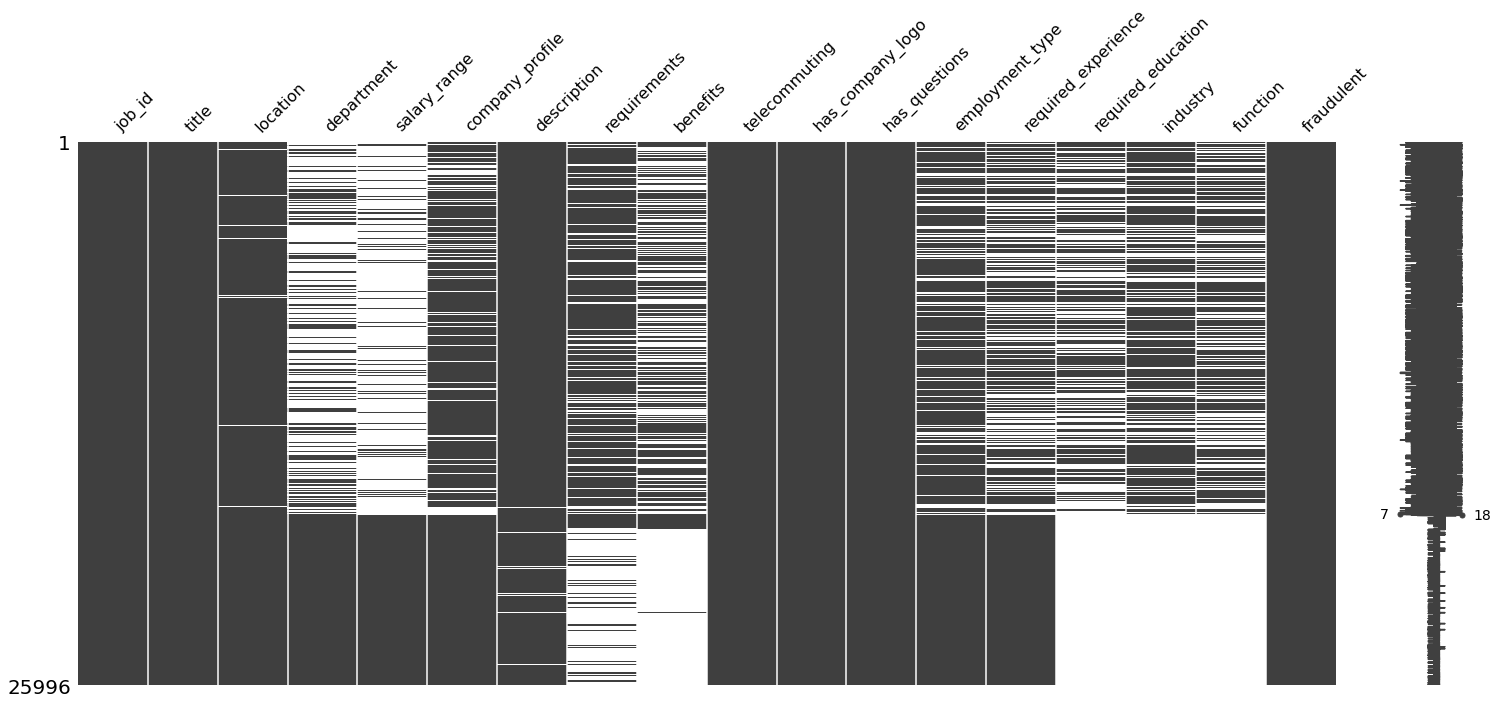

In [26]:
# Alternative way to have a quick glance to check missing values
missingno.matrix(dataset)

From the data, we understand that there are 0 duplicated rows, but alot of missing values, especially for department and salary range in the originally provided dataset. Other columns to note are employment_type, required_experience, required_education, industry, function, requirements and benefits. We will dive deep to understand each of this data column better to try and account for the missing values.

## 2. Feature Engineering

### 2.1 Location > Country

In [27]:
dataset['location_country'] = dataset['location'].str.split(',').str[0].str.strip()
dataset[['location_country']] = dataset[['location_country']].applymap(lambda x: x if x else np.NaN)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [28]:
dataset['location_country'].value_counts(dropna=False).head(10)

location_country
US     10656
SG      5230
NaN     3312
GB      2384
GR       940
CA       457
DE       383
NZ       333
IN       276
AU       214
Name: count, dtype: int64

### 2.2 Title, Company Profile, Description, Requirements, Benefits > Full Text

In [29]:
# Combine the 5 columns into a column called full_text

dataset['title_contain_urgent'] = dataset['title'].apply(lambda x: 1 if 'urgent' in x.lower() else 0)
dataset['have_company_profile'] = np.where(dataset['company_profile'].notnull(), 1, 0)
dataset['have_description'] = np.where(dataset['description'].notnull(), 1, 0)
dataset['have_requirements'] = np.where(dataset['requirements'].notnull(), 1, 0)
dataset['have_benefits'] = np.where(dataset['benefits'].notnull(), 1, 0)

dataset[['title']] = dataset[['title']].fillna('')
dataset[['company_profile']] = dataset[['company_profile']].fillna('')
dataset[['description']] = dataset[['description']].fillna('')
dataset[['requirements']] = dataset[['requirements']].fillna('')
dataset[['benefits']] = dataset[['benefits']].fillna('')
dataset['full_text'] = dataset['title'] + ' ' + dataset['company_profile'] + ' ' + dataset['description'] + ' ' + dataset['requirements'] + ' ' + dataset['benefits']

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...


#### 2.2.1 Full Text Readability

In [30]:
dataset['ft_flesch_score'] = dataset['full_text'].apply(textstat.flesch_reading_ease) # low score = very confusing
dataset['ft_fk_grade_level'] = dataset['full_text'].apply(textstat.flesch_kincaid_grade)

# # flesch score binning
# def map_to_flesch_score(score):
#     if score >= 90:
#         return "Very Easy"
#     elif 80 <= score <= 89:
#         return "Easy"
#     elif 70 <= score <= 79:
#         return "Fairly Easy"
#     elif 60 <= score <= 69:
#         return "Standard"
#     elif 50 <= score <= 59:
#         return "Fairly Difficult"
#     elif 30 <= score <= 49:
#         return "Difficult"
#     else:
#         return "Very Difficult"
    
# # grade level binning 
# def map_to_fk_grade_level(score):
#     if score >= 18:
#         return "Advanced"
#     elif 12 <= score <= 17:
#         return "Skilled"
#     elif 6 <= score <= 11:
#         return "Average"
#     elif 0 <= score <= 5:
#         return "Basic"
#     else:
#         return "Beginner"
    
# flesch score binning manual label encoding
def map_to_flesch_score(score):
    if score >= 90:
        return "1"
    elif 80 <= score <= 89:
        return "2"
    elif 70 <= score <= 79:
        return "3"
    elif 60 <= score <= 69:
        return "4"
    elif 50 <= score <= 59:
        return "5"
    elif 30 <= score <= 49:
        return "6"
    else:
        return "7"
    
# grade level binning manual label encoding
def map_to_fk_grade_level(score):
    if score >= 18:
        return "1"
    elif 12 <= score <= 17:
        return "2"
    elif 6 <= score <= 11:
        return "3"
    elif 0 <= score <= 5:
        return "4"
    else:
        return "5"
    
dataset['flesch_score_bin_ft'] = dataset['ft_flesch_score'].apply(map_to_flesch_score)

dataset['fk_grade_level_bin_ft'] = dataset['ft_fk_grade_level'].apply(map_to_fk_grade_level)

del dataset['ft_flesch_score']
del dataset['ft_fk_grade_level']

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",7,1
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,6,2
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,7,2
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,7,1
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,7,1


#### 2.2.2 Identify High Salary

In [31]:
def check_high_salary(text):
    lower_text = text.lower()
    if 'high paid' in lower_text or 'high pay' in lower_text or 'highly paid' in lower_text or 'high-paid' in lower_text:
        return 1
    else:
        return 0

dataset['high_salary'] = dataset['full_text'].apply(check_high_salary)
dataset.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft,high_salary
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",7,1,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,6,2,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,7,2,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,7,1,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,7,1,0


In [32]:
dataset['high_salary'].value_counts(dropna=False).head(10)

high_salary
0    25984
1       12
Name: count, dtype: int64

### 2.3 Department, Industry, Function > Category

In [33]:
# fill in missing values with the help of key words from 'title'
str_list = ['Engineer','Account','Accountant','Accounting','Developer','Sales','Marketing','Beauty','Service','Customer','Consumer',
'Customer','Writer','Pet','Architect', 'Dog', 'Game', 'Mobile', 'Design', 'Financial','Programmer']

for strs in str_list:
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['department'].isna()),'department'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['department'].mode()[0]
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['industry'].isna()),'industry'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['industry'].mode()[0]
  dataset.loc[(dataset['title'].str.contains(strs, case=False, na=False)) & (dataset['function'].isna()),'function'] = \
  dataset[dataset['title'].str.contains(strs, case=False, na=False)]['function'].mode()[0]

In [34]:
# combine into 'category'
dataset[['department']] = dataset[['department']].fillna('')
dataset[['industry']] = dataset[['industry']].fillna('')
dataset[['function']] = dataset[['function']].fillna('')
dataset['category'] = dataset['department'] + ' ' + dataset['industry'] + ' ' + dataset['function']

punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS
nlp = spacy.load("en_core_web_md")

def transform(text):
    tokens = nlp(text.lower())
    tokens = list(set(tokens)) # remove duplicates before processing
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word for word in tokens]
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    tokens = list(set(tokens)) # remove duplicates after processing
    tokens.sort() # order words by a standard format so categories with same words can be grouped together
    output = " ".join(tokens)
    output = re.sub('\s{2,}', " ", output).strip()
    return output

dataset['category'] = dataset['category'].map(transform)
dataset[['category']] = dataset[['category']].map(lambda x: 'unspecified' if x == '' else x)

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft,high_salary,category
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,Marketing and Advertising,Marketing,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",7,1,0,advertising marketing
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,6,2,0,advertising customer marketing service success
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,,,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,7,2,0,unspecified
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,7,1,0,computer sale software
4,5,Bill Review Manager,"US, FL, Fort Worth",,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,7,1,0,care health hospital provider


In [35]:
fraud_cat = dataset[dataset.fraudulent == 1].category
nofraud_cat = dataset[dataset.fraudulent == 0].category

In [36]:
fraud_cat.value_counts(dropna=False)

category
unspecified                                                       140
energy engineering oil                                             57
advertising marketing                                              54
human resource                                                     36
finance financial service                                          32
                                                                 ... 
computer energy engineering oil software                            1
customer information service technology                             1
customer human information resource service support technology      1
business customer development information service technology        1
advertising finance marketing sale                                  1
Name: count, Length: 356, dtype: int64

In [37]:
nofraud_cat.value_counts(dropna=False)

category
unspecified                                                          1527
computer engineering software                                        1003
engineering information service technology                            846
education management                                                  756
computer engineering information software technology                  656
                                                                     ... 
development fitness health information mobile technology wellness       1
analyst energy financial oil                                            1
customer internet service warehouse                                     1
child education institute management nature                             1
consulting information service technology                               1
Name: count, Length: 4791, dtype: int64

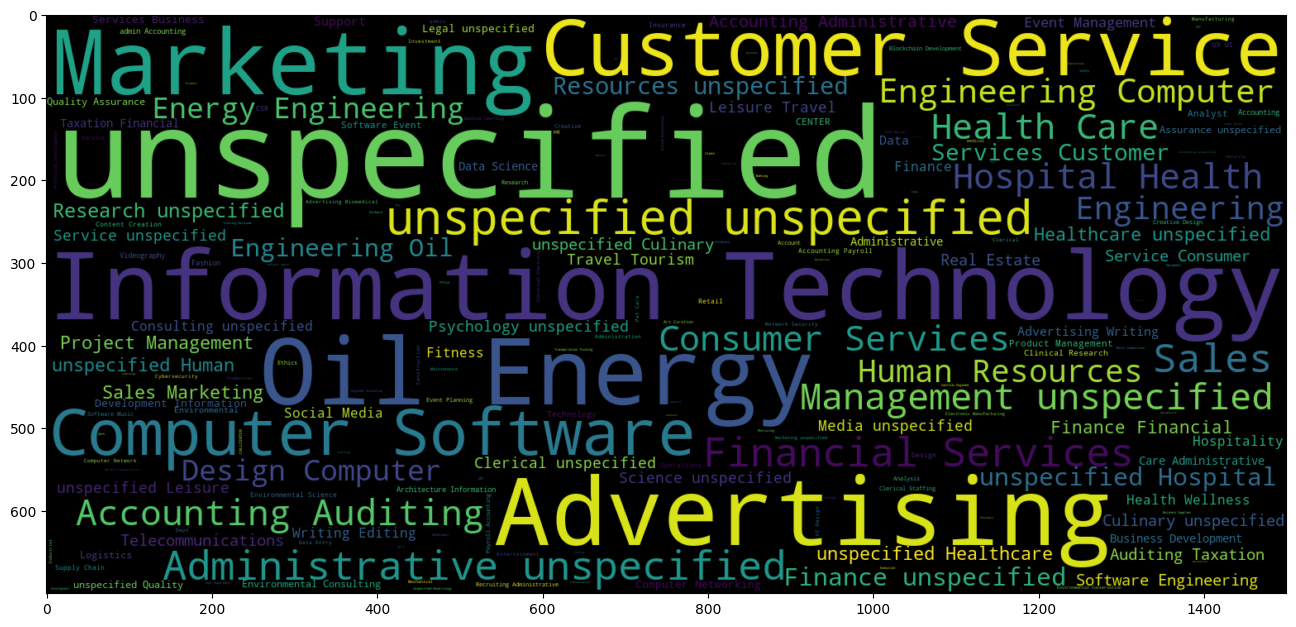

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_cat)))
plt.imshow(wc,interpolation = 'bilinear')

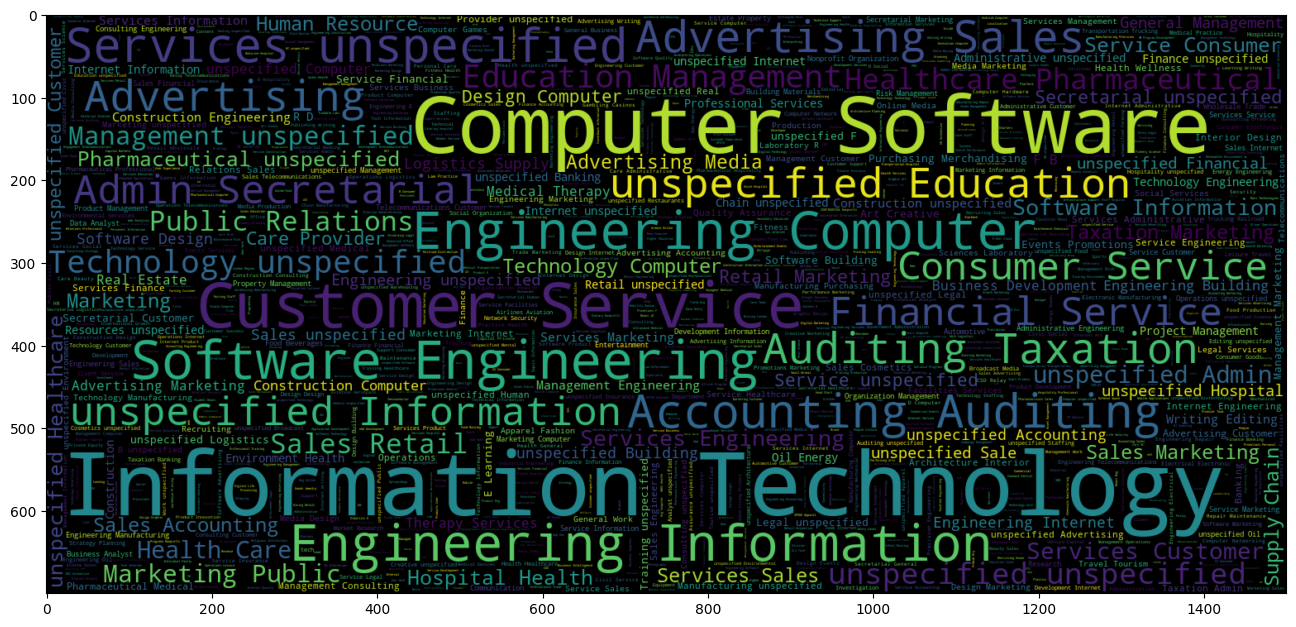

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nofraud_cat)))
plt.imshow(wc,interpolation = 'bilinear')

## 3. Data Cleaning

In [38]:
# drop useless columns
drop_cols = ['job_id','title','company_profile','description','requirements','benefits','department','industry','function']
dataset = dataset.drop(drop_cols,axis=1)
dataset.head()

,location,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,location_country,title_contain_urgent,have_company_profile,have_description,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft,high_salary,category
0,"US, NY, New York",NaN,0,1,0,Other,Internship,NaN,0,US,0,1,1,1,0,"Marketing Intern We're Food52, and we've creat...",7,1,0,advertising marketing
1,"NZ, , Auckland",NaN,0,1,0,Full-time,Not Applicable,NaN,0,NZ,0,1,1,1,1,Customer Service - Cloud Video Production 90 S...,6,2,0,advertising customer marketing service success
2,"US, IA, Wever",NaN,0,1,0,NaN,NaN,NaN,0,US,0,1,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,7,2,0,unspecified
3,"US, DC, Washington",NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,0,US,0,1,1,1,1,Account Executive - Washington DC Our passion ...,7,1,0,computer sale software
4,"US, FL, Fort Worth",NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,0,US,0,1,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,7,1,0,care health hospital provider


### 3.1 Handle Missing Values

In [39]:
dataset.isna().sum()

location                   346
salary_range             15017
telecommuting                0
has_company_logo             0
has_questions                0
employment_type           3471
required_experience       7084
required_education       16221
fraudulent                   0
location_country          3312
title_contain_urgent         0
have_company_profile         0
have_description             0
have_requirements            0
have_benefits                0
full_text                    0
flesch_score_bin_ft          0
fk_grade_level_bin_ft        0
high_salary                  0
category                     0
dtype: int64

#### 3.1.1 Salary Range 

We will drop the Salary Range as there are too many missing values. 

In [40]:
del dataset['salary_range']

#### 3.1.2 Location

We will only keep country information. Missing values are filled with 'unspecfied'.

In [41]:
del dataset['location']
dataset['location_country'] = dataset['location_country'].fillna('unspecified')

#### 3.1.3 employment_type, required_experience, required_education

In [42]:
# first fill in employment_type using 'title', but if no key words, fill in with 'unspecified'
dataset[['employment_type']] = dataset[['employment_type']].fillna('unspecified')

# then, fill in experience & education with the mode in each sub-group of employment_type
# Other, Full-time, unspecified, Part-time, Contract, Temporary
employ_type_list = ['Full-time','Other','Part-time','Contract','Temporary','unspecified']
for employ_type in employ_type_list:
   dataset.loc[(dataset['employment_type']==employ_type) & (dataset['required_experience'].isna()),'required_experience'] = dataset[dataset['employment_type']==employ_type]['required_experience'].mode()[0]
   dataset.loc[(dataset['employment_type']==employ_type) & (dataset['required_education'].isna()),'required_education'] = dataset[dataset['employment_type']==employ_type]['required_education'].mode()[0]
   
dataset[['required_experience','required_education']] = dataset[['required_experience','required_education']].fillna('unspecified')

In [43]:
dataset.isna().sum()

telecommuting            0
has_company_logo         0
has_questions            0
employment_type          0
required_experience      0
required_education       0
fraudulent               0
location_country         0
title_contain_urgent     0
have_company_profile     0
have_description         0
have_requirements        0
have_benefits            0
full_text                0
flesch_score_bin_ft      0
fk_grade_level_bin_ft    0
high_salary              0
category                 0
dtype: int64

### 3.2 Drop Columns with Low Variance

In [44]:
# Filter numeric columns only
numeric_columns = dataset.select_dtypes(include="number")

# Calculate the variance for numeric columns
variance_info = numeric_columns.var()

# Display the variance for each numeric column
print(variance_info)

telecommuting           0.050956
has_company_logo        0.126009
has_questions           0.232130
fraudulent              0.055461
title_contain_urgent    0.002953
have_company_profile    0.111062
have_description        0.009676
have_requirements       0.225521
have_benefits           0.246034
high_salary             0.000461
dtype: float64


In [45]:
del dataset['have_description']

### 3.3 Clean Text Data

In [46]:
def remove_stop_words(doc):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  docs = list(set(doc.split(' ')) - stop_words)
  return docs

def simple_stemmer(doc):
  stemmer= PorterStemmer()
  doc = ' '.join([stemmer.stem(word) for word in doc.split(' ')])
  return doc

# to clean data
def normalise_text(text,remove_stop_words=True):
    text = fix_text(text)
    text = text.lower() # lowercase
    text = text.replace("'","").replace("’","") # remove apostrophes ("can't">"cant")
    text = re.sub('#\S+#', " ", text) # removes #URL_...# #PHONE_...# #EMAIL_...# #*_...#
    text = re.sub('\xa0', " ", text) # remove \xa0
    text = re.sub('<.*?>'," ",text) # remove <> tags
    text = re.sub('#\S+', " ", text) # replaces hashtags
    text = re.sub('@\S+', " ", text)  # remove mentions
    text = re.sub("http\S+", " ", text) # remove URL addresses starting with http
    text = re.sub('www\S+', " ", text) # remove URL addresses starting with www
    text = re.sub('\d+', lambda x: ' '+num2words(x.group(), to='cardinal')+' ', text) # convert numbers to words ('food52'>'food fifty-two ')
    text = re.sub("[^a-zA-Z]", " ", text) # letters only
    text = re.sub('\s{2,}', " ", text).strip() # replace more than or equal to two white spaces into one white space
    if remove_stop_words:
      stop_words = set(nltk.corpus.stopwords.words('english'))
      text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    # if stem_words:
    # stemmer = PorterStemmer()
    # text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [47]:
text_cols = ['category','employment_type','required_experience','required_education']
for col in text_cols:
   dataset[col] = dataset[col].apply(lambda x: normalise_text(x,remove_stop_words=False))
dataset.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,location_country,title_contain_urgent,have_company_profile,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft,high_salary,category
0,0,1,0,other,internship,bachelors degree,0,US,0,1,1,0,"Marketing Intern We're Food52, and we've creat...",7,1,0,advertising marketing
1,0,1,0,full time,not applicable,bachelors degree,0,NZ,0,1,1,1,Customer Service - Cloud Video Production 90 S...,6,2,0,advertising customer marketing service success
2,0,1,0,unspecified,not applicable,high school or equivalent,0,US,0,1,1,0,Commissioning Machinery Assistant (CMA) Valor ...,7,2,0,unspecified
3,0,1,0,full time,mid senior level,bachelors degree,0,US,0,1,1,1,Account Executive - Washington DC Our passion ...,7,1,0,computer sale software
4,0,1,1,full time,mid senior level,bachelors degree,0,US,0,1,1,1,Bill Review Manager SpotSource Solutions LLC i...,7,1,0,care health hospital provider


In [48]:
dataset['full_text'] = dataset['full_text'].apply(lambda x: normalise_text(x))
dataset['text_len'] = dataset['full_text'].apply(lambda x: len(x.split(' ')))
dataset.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,location_country,title_contain_urgent,have_company_profile,have_requirements,have_benefits,full_text,flesch_score_bin_ft,fk_grade_level_bin_ft,high_salary,category,text_len
0,0,1,0,other,internship,bachelors degree,0,US,0,1,1,0,marketing intern food fifty two weve created g...,7,1,0,advertising marketing,267
1,0,1,0,full time,not applicable,bachelors degree,0,NZ,0,1,1,1,customer service cloud video production ninety...,6,2,0,advertising customer marketing service success,567
2,0,1,0,unspecified,not applicable,high school or equivalent,0,US,0,1,1,0,commissioning machinery assistant cma valor se...,7,2,0,unspecified,235
3,0,1,0,full time,mid senior level,bachelors degree,0,US,0,1,1,1,account executive washington dc passion improv...,7,1,0,computer sale software,497
4,0,1,1,full time,mid senior level,bachelors degree,0,US,0,1,1,1,bill review manager spotsource solutions llc g...,7,1,0,care health hospital provider,370


In [49]:
# check duplicates
dataset.duplicated().sum()

2071

In [50]:
# drop duplicates
dataset = dataset.drop_duplicates()

In [51]:
# save to an output file
dataset.to_csv('../Raw Data Files/final_job_posting.csv', index=False)